# Linear Regression from a Predictive Perspective

In this Laboratory, we will see an example of linear regression from a predictive-analysis perspective. We well see all the best practices to split the data and select the model with best performance. 

## California Housing Dataset
We'll use the California Housing dataset provided by the `scikit-learn` library. Let us load the data as a dataframe and have a look at the data description:

In [ ]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
print(data['DESCR'])
data['data']

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


The dataset contains $8$ variables. The independent variable is `MedInc`, the average value of houses in a given suburb, while all other variables are independent. For our aims, we will treat the data as a matrix of numerical variables. We could easily convert the dataframe in this format, but scikit-learn allows to load the data directly in this format:

In [ ]:
# let us load the data without passing as_frame=True
data = fetch_california_housing()
X = data.data # the features
y = data.target # the targets

print(X.shape, y.shape)

(20640, 8) (20640,)


## Data Splitting
We will split the dataset into a training, a validation and a test set using the `train_test_split` function:

In [ ]:
from sklearn.model_selection import train_test_split
# We'll do a 60:20:20 split
val_prop = 0.2
test_prop = 0.2

# We'll split the data in two steps - first let's create a test set and a combined trainval set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

# We'll now split the combined trainval into train and val set with the chosen proportions
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=test_prop/(1-test_prop), random_state=42)

# Let us check shapes and proportions
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])

(12384, 8) (4128, 8) (4128, 8)
0.6 0.2 0.2


The `train_test_split` function will split the data randomly. We are passing a fixed `random_state` to be able to replicate the results, but, in general, we should avoid that if we want the split to be truly random (though it is common to use random seeds for splitting in research). Note that, while the split is random, the function makes sure that the i-th element of the y variable corresponds to the i-th element of the X variable after the split.

We will now reason mainly on the validation set, comparing different models and parameter configurations. Once we are done with our explorations, we'll check the final results on the test set.

### Data Normalization
We'll start by normalizing the data with z-scoring. This will prove useful later when we use certain algorithms (e.g., regularization). Note that we have not normalized data before because we need to **make sure that even mean and standard deviation parameters are not computed on the validation or test set**. While this may seem a trivial detail, it is important to follow this rule as strictly as possible to avoid bias. We can normalize the data with the `StandardScaler` object:

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # tunes the internal parameters of the standard scaler

X_train = scaler.transform(X_train) # does not tune the parameters anymore
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Scikit-learn objects have a unified object-oriented interface. Each algorithm is an object (e.g., `StandardScaler`) with standard methods, such as:
 * A `fit` method to tune the internal parameters of the algorithm. In this case, it is a vector of means and a vector of standard deviations, but in the case of a linear regression it will be a vector of weights;
 * A `transform` method to transform the data. Note that in this stage no parameters are tuned, so we can safely apply this method to validation and test data. This method only applies to objects which transform the data, such as the standard scaler;
 * A `predict` method to obtain predictions. This applies only to predictive models, such as a linear regressor;
 * A `score` method to obtain a standard performance measure on the test or validation data. Also this only applies to predictive models.

We will see examples of the last two methods later.

## Linear Regressor

We will start by training a linear regressor. We will use scikit-learn's implementation which does not provide statistical details (e.g., p-values) but is optimized for predictive modeling. The train/test interface is the same as above:

In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train) # this tunes the internal parameters of the model

# Let us print the model's parameters
print(linear_regressor.coef_) 
print(linear_regressor.intercept_)

[ 0.86025287  0.1200073  -0.28039183  0.31208687 -0.00957447 -0.02615781
 -0.88821331 -0.86190739]
2.0680774192504314


We can obtain predictions on the validation set using the `predict` method:

In [ ]:
y_val_pred = linear_regressor.predict(X_val)
print(y_val_pred.shape)

(4128,)


The function returns a vector of $4128$ predictions, one for each example in the validation set. We can now evaluate the predictions using regression evaluation measures. We will use the standard implementation of the main evaluation measures as provided by scikit-learn:

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print(mae, mse, rmse)

0.533334644741504 0.5297481095803488 0.727837969317587


All evaluation measures in scikit-learn follow the `evaluation_measure(y_true, y_pred)` convention. Note that the target variable `MedInc` is measured in tens of thousands of dollars, so an MAE of about $0.5$ corresponds to an average error of about $5000$ dollars. This is not that bad if we consider the mean and standard deviation of targets:

In [ ]:
y_train.mean(), y_train.std()

(2.068077419250646, 1.1509151433486544)

Each predictor in scikit-learn also provides a `score` method which takes as input the validation (or test) inputs and outputs and computes some standard evaluation measures. By default the linear regressor in scikit-learn returns the $R^2$ value:

In [ ]:
linear_regressor.score(X_val, y_val)

0.6142000785497264

While we are mainly interested in the performance of the model on the validation set (and ultimately on those on the test set), it is still useful to assess the performance on the training set for model diagnostics. For instance, if we see a big discrepancy between training and validation errors, then we can imagine that some overfitting is going on:

In [ ]:
y_train_pred = linear_regressor.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)

print(mae_train, mse_train, rmse_train)

0.5266487515751342 0.5143795055231386 0.7172025554354492


We can see that, while there are some differences between training and test performance, those are minor, so we can deduce that there is no significant overfitting going on.

> We should note that we should **always expect a certain degree of overfitting, depending on the task, the data and the model**. When the difference between train and test error is large, and hence there is significant overfitting, we can try to reduce this effect with regularization techniques.

To better compare models, we will now store the results of our analyses in a dataframe:

In [ ]:
import pandas as pd
california_housing_val_results = pd.DataFrame({
    'Method': ['Linear Regressor'],
    'Parameters': [''],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838


It is common to use the word "method" to refer to a predictive algorithm or pipeline.

## Non-Linear Regression
Let us now try to fit a non-linear regressor. We will use polynomial regression with different polynomial degrees. To do so, we will perform an explicit polynomial expansion of the features using the `PolynomialFeatures` object. For convenience, we will define a function performing training and validation and returning both training and validation performance:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
def trainval_polynomial(degree):
    pf = PolynomialFeatures(degree)
    # While the model does not have any learnable parameters, the "fit" method here is used to compute the output number of features
    pf.fit(X_train)
    X_train_poly = pf.transform(X_train)
    X_val_poly = pf.transform(X_val)

    polyreg = LinearRegression() # a Polynomial regressor is simply a linear regressor using polynomial features
    polyreg.fit(X_train_poly, y_train)

    y_poly_train_pred = polyreg.predict(X_train_poly)
    y_poly_val_pred = polyreg.predict(X_val_poly)

    mae_train = mean_absolute_error(y_train, y_poly_train_pred)
    mse_train = mean_squared_error(y_train, y_poly_train_pred)
    rmse_train = mean_squared_error(y_train, y_poly_train_pred, squared=False)

    mae_val = mean_absolute_error(y_val, y_poly_val_pred)
    mse_val = mean_squared_error(y_val, y_poly_val_pred)
    rmse_val = mean_squared_error(y_val, y_poly_val_pred, squared=False)

    return mae_train, mse_train, rmse_train, mae_val, mse_val, rmse_val

Let us now see what happens with different degrees:

In [ ]:
for d in range(1,4):
    print("DEGREE: {} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(d,"MAE", "MSE", "RMSE", *trainval_polynomial(d)))

DEGREE: 1 
           MAE      MSE     RMSE
TRAIN     0.53     0.51     0.72 
VAL       0.53     0.53     0.73


DEGREE: 2 
           MAE      MSE     RMSE
TRAIN     0.46     0.42     0.65 
VAL       0.48     0.91     0.95


DEGREE: 3 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.58 
VAL      23.48 2157650.15  1468.89




## Ridge Regularization
We can see that, as the polynomial gets larger, the effect of overfitting increases. We can try to reduce this effect with Ridge or Lasso regularization. We'll focus on degree $2$ and try to apply ridge regression to it. Since Ridge regression relies on a parameter, we will try some values of the regularization parameter $\alpha$ (as it is called by sklearn). Let us define a function for convenience:

In [ ]:
from sklearn.linear_model import Ridge
def trainval_polynomial_ridge(degree, alpha):
    pf = PolynomialFeatures(degree)
    # While the model does not have any learnable parameters, the "fit" method here is used to compute the output number of features
    pf.fit(X_train)
    X_train_poly = pf.transform(X_train)
    X_val_poly = pf.transform(X_val)

    polyreg = Ridge(alpha=alpha) # a Polynomial regressor is simply a linear regressor using polynomial features
    polyreg.fit(X_train_poly, y_train)

    y_poly_train_pred = polyreg.predict(X_train_poly)
    y_poly_val_pred = polyreg.predict(X_val_poly)

    mae_train = mean_absolute_error(y_train, y_poly_train_pred)
    mse_train = mean_squared_error(y_train, y_poly_train_pred)
    rmse_train = mean_squared_error(y_train, y_poly_train_pred, squared=False)

    mae_val = mean_absolute_error(y_val, y_poly_val_pred)
    mse_val = mean_squared_error(y_val, y_poly_val_pred)
    rmse_val = mean_squared_error(y_val, y_poly_val_pred, squared=False)

    return mae_train, mse_train, rmse_train, mae_val, mse_val, rmse_val

Let us now see the results for different values of $\alpha$. $\alpha=0$ means no regularization:

In [ ]:
print("RIDGE, DEGREE: 2")
for alpha in [0,100,200,300,400]:
    print("Alpha: {:0.2f} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(alpha,"MAE", "MSE", "RMSE", *trainval_polynomial_ridge(2,alpha)))

RIDGE, DEGREE: 2
Alpha: 0.00 
           MAE      MSE     RMSE
TRAIN     0.46     0.42     0.65 
VAL       0.48     0.91     0.96


Alpha: 100.00 
           MAE      MSE     RMSE
TRAIN     0.47     0.43     0.66 
VAL       0.48     0.54     0.74


Alpha: 200.00 
           MAE      MSE     RMSE
TRAIN     0.48     0.44     0.67 
VAL       0.49     0.51     0.72


Alpha: 300.00 
           MAE      MSE     RMSE
TRAIN     0.49     0.46     0.68 
VAL       0.50     0.50     0.71


Alpha: 400.00 
           MAE      MSE     RMSE
TRAIN     0.50     0.47     0.68 
VAL       0.51     0.51     0.71




We can see how, as alpha increases, the error on the training set increases, while the error on the test set decreases. For $\alpha=300$ we obtained a slightly better result than our linear regressor: 

In [ ]:
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838


Let us see if we can improve the results with a polynomial of degree 3:

In [ ]:
print("RIDGE, DEGREE: 3")
for alpha in [0,1,10,20]:
    print("Alpha: {:0.2f} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(alpha,"MAE", "MSE", "RMSE", *trainval_polynomial_ridge(3,alpha)))

DEGREE: 3
Alpha: 0.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.58 
VAL      23.50 2162209.37  1470.45


Alpha: 1.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.58 
VAL      15.59 934580.07   966.74


Alpha: 10.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.59 
VAL       1.57  4867.65    69.77


Alpha: 20.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.35     0.59 
VAL       1.78  6690.78    81.80




Let us add the results of Polynomial regression of degree 2 with and without regularization:

In [ ]:
poly2 = trainval_polynomial_ridge(2,0)
poly2_ridge300 = trainval_polynomial_ridge(2,300)
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Polynomial Regressor', 'Parameters': 'degree=2', 'MAE':poly2[-3], 'MSE':poly2[-2], 'RMSE':poly2[-1]}, index=[1]),
    pd.DataFrame({'Method':'Polynomial Ridge Regressor', 'Parameters': 'degree=2, alpha=300', 'MAE':poly2_ridge300[-3], 'MSE':poly2_ridge300[-2], 'RMSE':poly2_ridge300[-1]}, index=[2])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480448,0.912976,0.955498
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039


## Lasso Regression
Let us now try the same with Lasso regression:

In [ ]:
from sklearn.linear_model import Lasso
def trainval_polynomial_lasso(degree, alpha):
    pf = PolynomialFeatures(degree)
    # While the model does not have any learnable parameters, the "fit" method here is used to compute the output number of features
    pf.fit(X_train)
    X_train_poly = pf.transform(X_train)
    X_val_poly = pf.transform(X_val)

    polyreg = Lasso(alpha=alpha) # a Polynomial regressor is simply a linear regressor using polynomial features
    polyreg.fit(X_train_poly, y_train)

    y_poly_train_pred = polyreg.predict(X_train_poly)
    y_poly_val_pred = polyreg.predict(X_val_poly)

    mae_train = mean_absolute_error(y_train, y_poly_train_pred)
    mse_train = mean_squared_error(y_train, y_poly_train_pred)
    rmse_train = mean_squared_error(y_train, y_poly_train_pred, squared=False)

    mae_val = mean_absolute_error(y_val, y_poly_val_pred)
    mse_val = mean_squared_error(y_val, y_poly_val_pred)
    rmse_val = mean_squared_error(y_val, y_poly_val_pred, squared=False)

    return mae_train, mse_train, rmse_train, mae_val, mse_val, rmse_val

In [ ]:
print("LSSO, DEGREE: 2")
for alpha in [0.02,0.03,0.04,0.05, 0.06]:
    print("Alpha: {:0.2f} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(alpha,"MAE", "MSE", "RMSE", *trainval_polynomial_lasso(2,alpha)))

LSSO, DEGREE: 2
Alpha: 0.02 
           MAE      MSE     RMSE
TRAIN     0.52     0.51     0.71 
VAL       0.54     1.19     1.09


Alpha: 0.03 
           MAE      MSE     RMSE
TRAIN     0.55     0.55     0.74 
VAL       0.55     0.59     0.77


Alpha: 0.04 
           MAE      MSE     RMSE
TRAIN     0.56     0.57     0.76 
VAL       0.57     0.59     0.77


Alpha: 0.05 
           MAE      MSE     RMSE
TRAIN     0.58     0.60     0.78 
VAL       0.58     0.61     0.78


Alpha: 0.06 
           MAE      MSE     RMSE
TRAIN     0.60     0.63     0.80 
VAL       0.60     0.64     0.80




Lasso regression does not seem to improve results. Let us put the results obtained for $\alpha=0.04$ to the dataframe:

In [ ]:
poly2_lasso004 = trainval_polynomial_lasso(2,0.04)
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Polynomial Lasso Regressor', 'Parameters': 'degree=2, alpha=0.04', 'MAE':poly2_lasso004[-3], 'MSE':poly2_lasso004[-2], 'RMSE':poly2_lasso004[-1]}, index=[3])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480448,0.912976,0.955498
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180


## Grid Search

Polynomial regression and ridge regression have parameters to optimize. We have so far optimized them manually. However, in practice, it is common to perform a grid search. This consists in defining a grid of possible values to try and train/validate many models, to finally choose the one with best performance.

This can be done manually as shown in the following example:

In [ ]:
def grid_search(alphas=range(200,400,25), degrees=range(5)):
    best_mse = np.inf
    for a in alphas:
        for d in degrees:
            print(f"Evaluating a={a} d={d} MSE=", end='')
            results = trainval_polynomial_ridge(d,a)
            mse = results[-2]
            print(f"{mse:0.2f}")
            if mse<best_mse:
                best_mse = mse
                best_alpha = a
                best_degree = d

    return best_mse, best_alpha, best_degree
grid_search()

Evaluating a=200 d=0 MSE=1.37
Evaluating a=200 d=1 MSE=0.53
Evaluating a=200 d=2 MSE=0.51
Evaluating a=200 d=3 MSE=8161.95
Evaluating a=200 d=4 MSE=10884172.40
Evaluating a=225 d=0 MSE=1.37
Evaluating a=225 d=1 MSE=0.53
Evaluating a=225 d=2 MSE=0.51
Evaluating a=225 d=3 MSE=6710.18
Evaluating a=225 d=4 MSE=7243991.68
Evaluating a=250 d=0 MSE=1.37
Evaluating a=250 d=1 MSE=0.53
Evaluating a=250 d=2 MSE=0.51
Evaluating a=250 d=3 MSE=5542.92
Evaluating a=250 d=4 MSE=4880680.92
Evaluating a=275 d=0 MSE=1.37
Evaluating a=275 d=1 MSE=0.53
Evaluating a=275 d=2 MSE=0.50
Evaluating a=275 d=3 MSE=4598.99
Evaluating a=275 d=4 MSE=3312886.74
Evaluating a=300 d=0 MSE=1.37
Evaluating a=300 d=1 MSE=0.54
Evaluating a=300 d=2 MSE=0.50
Evaluating a=300 d=3 MSE=3831.00
Evaluating a=300 d=4 MSE=2255901.13
Evaluating a=325 d=0 MSE=1.37
Evaluating a=325 d=1 MSE=0.54
Evaluating a=325 d=2 MSE=0.50
Evaluating a=325 d=3 MSE=3202.40
Evaluating a=325 d=4 MSE=1534556.72
Evaluating a=350 d=0 MSE=1.37
Evaluating a=35

(0.504155356305115, 300, 2)

Testing a range of values, we found that best results are obtained with degree equal to $2$ and $\alpha=300$.

## Scikit-Learn Pipelines
Often, a predictive model is obtained by stacking different components. For instance, in our example, a Polynomial regressor is obtained by following this pipeline:
* Data standardization;
* Polynomial feature expansion:
* Ridge regression.

While these steps can be carried out independently as seen before, scikit-learn offers the  powerful interface of `Pipelines` to automate this process. A pipeline stacks different components together and makes it convenient to change some of elements of the pipeline or to optimize its parameters. Let us define a pipeline as the one discussed above:

In [ ]:
from sklearn.pipeline import Pipeline
polynomial_regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial_expansion', PolynomialFeatures()),
    ('ridge_regression', Ridge())
])

To take full advantage of the pipeline, we will re-load the dataset and avoid applying the standard scaler manually:

In [ ]:
# let us load the data without passing as_frame=True
data = fetch_california_housing()
X = data.data # the features
y = data.target # the targets

# We'll do a 60:20:20 split
val_prop = 0.2
test_prop = 0.2

# We'll split the data in two steps - first let's create a test set and a combined trainval set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

# We'll now split the combined trainval into train and val set with the chosen proportions
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=test_prop/(1-test_prop), random_state=42)

# Let us check shapes and proportions
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])

(12384, 8) (4128, 8) (4128, 8)
0.6 0.2 0.2


Our pipeline has two parameters that we need to set: the Ridge regressor's $\alpha$ and the degree of the polynomial. We can set these parameters as follows:

In [ ]:
# We use the notation "object__parameter" to identify parameter names
polynomial_regressor.set_params(polynomial_expansion__degree=2, ridge_regression__alpha=300)

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial_expansion', PolynomialFeatures()),
                ('ridge_regression', Ridge(alpha=300))])

We can now fit and test the model as follows:

In [ ]:
polynomial_regressor.fit(X_train, y_train)
y_val_pred = polynomial_regressor.predict(X_val)

mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred, squared=False)

(0.4992282794518701, 0.504155356305115, 0.7100389822433096)

## Grid Search with Cross Validation
Scikit-learn offers a powerful interface to perform grid search with cross validation. In this case, rather than using a fixed training set, a K-Fold validation is performed for each parameter choice in order to find the best performing parameter combination. This is convenient when a validation set is not available. We will combine this approach with the pipelines to easily automate the search of optimal parameters:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

gs = GridSearchCV(polynomial_regressor, param_grid={'polynomial_expansion__degree':range(0,5), 'ridge_regression__alpha':range(200,400,25)}, scoring=make_scorer(mean_squared_error,greater_is_better=False))

We will now fit the model on the union of training and validation set:

In [ ]:
gs.fit(X_trainval, y_trainval)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_expansion',
                                        PolynomialFeatures(degree=0)),
                                       ('ridge_regression', Ridge(alpha=200))]),
             param_grid={'polynomial_expansion__degree': range(0, 5),
                         'ridge_regression__alpha': range(200, 400, 25)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

Let us check the best parameters:

In [ ]:
gs.best_params_

{'polynomial_expansion__degree': 2, 'ridge_regression__alpha': 250}

These are similar to the ones found with our previous grid search. We can now fit the final model on the training set and evaluate on the validation set:

In [ ]:
polynomial_regressor.set_params(**gs.best_params_)
polynomial_regressor.fit(X_train, y_train)
y_val_pred = polynomial_regressor.predict(X_val)
mae, mse, rmse = mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred, squared=False)

print(mae, mse, rmse)

0.49556977845052963 0.506286626421441 0.711538211497767


Let us add this result to our dataframe:

In [ ]:
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Cross-Validated Polynomial Ridge Regressor', 'Parameters': 'degree=2, alpha=250', 'MAE':mae, 'MSE':mse, 'RMSE':rmse}, index=[4])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480448,0.912976,0.955498
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180
4,Cross-Validated Polynomial Ridge Regressor,"degree=2, alpha=250",0.495570,0.506287,0.711538


## Other Regression Algorithms

Thanks to the unified interface of scikit-learn objects, we can easily train other algorithms even if we do not know how they work inside. Of course, to be able to optimize them in the most complex situations we will need to know how they work internally. The following code shows how to train a neural network (we will not see the algorithm formally):

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp_regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regression', MLPRegressor())
])

mlp_regressor.fit(X_train,y_train)
y_val_pred = mlp_regressor.predict(X_val)
mae, mse, rmse = mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred, squared=False)
mae, mse, rmse

/Users/furnari/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.3802246120708036, 0.3067554686836898, 0.5538550971903119)

In [ ]:
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Neural Network', 'Parameters': '', 'MAE':mae, 'MSE':mse, 'RMSE':rmse}, index=[4])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480448,0.912976,0.955498
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180
4,Cross-Validated Polynomial Ridge Regressor,"degree=2, alpha=250",0.495570,0.506287,0.711538
4,Neural Network,,0.380225,0.306755,0.553855


## Comparison and Model Selection
We can now compare the performance of the different models using the table:

In [ ]:
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480448,0.912976,0.955498
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180
4,Cross-Validated Polynomial Ridge Regressor,"degree=2, alpha=250",0.495570,0.506287,0.711538
4,Neural Network,,0.380225,0.306755,0.553855


Alternatively, we can visualize the results graphically:

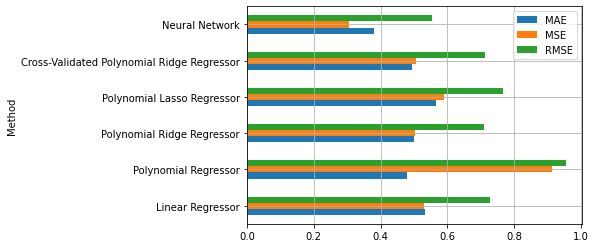

In [ ]:
california_housing_val_results.plot.barh(x='Method')
plt.grid()
plt.show()

From the analysis of the validation performance, it is clear that the neural network performs better. We can now compute the final performance on the test set:

In [ ]:
y_test_pred = mlp_regressor.predict(X_test)
mae, mse, rmse = mean_absolute_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred, squared=False)
mae, mse, rmse

(0.37814683358719486, 0.31599512987902556, 0.562134441107308)